In [6]:
import numpy as np
import xarray as xr
import boule as bl

In [3]:
import importlib
import functions as md

importlib.reload(md)  # Reload the module

print(md.__file__)

/home/eroskerouak/physical-geodesy/code/functions.py


In [7]:
ellipsoid = bl.GRS80
first_eccentricity = ellipsoid.first_eccentricity
print(f"first_eccentricity: {first_eccentricity}")

second_eccentricity = ellipsoid.second_eccentricity
print(f"second_eccentricity: {second_eccentricity}")

first_eccentricity: 0.08181919104281579
second_eccentricity: 0.0820944381519172


In [8]:
first_eccentricity_2 = first_eccentricity**2
print(f"first_eccentricity_2: {first_eccentricity_2}")

first_eccentricity_2: 0.006694380022900788


In [33]:
gravity_equator = ellipsoid.gravity_equator
print(gravity_equator)

9.78032677153605


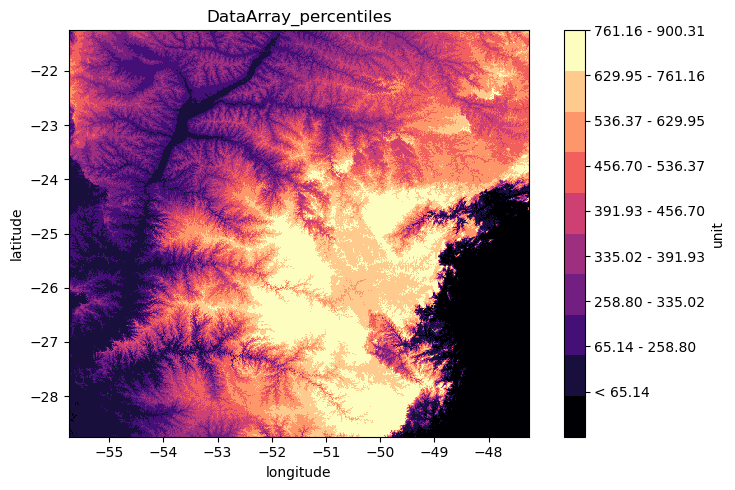

In [9]:
# Importando o MDE

geotiff_path = '../data/MDS_MERIT_SRTM15PLUS_900m_fill.tif'
elevation = md.geotiff_to_dataarray(geotiff_path)
elevation = elevation.rename({'x': 'longitude', 'y': 'latitude'})

md.plot_DataArray_percentiles(
    elevation, 
    x='longitude', 
    y='latitude', 
    label='unit', 
    title='DataArray_percentiles', 
    cmap='magma', 
    num_classes=10
    )

In [ ]:
sin_half = np.sin(psi / 2)
cos_psi = np.cos(psi)


S_psi = (1 / sin_half) - 6 * sin_half + 1 - 5 * cos_psi - 3 * cos_psi * np.log(sin_half**2 + sin_half)

In [28]:
latP = - (25 + 26/60 + 54.12695/3600) # em graus decimais
longP = - (49 + 13/60 + 51.43717/3600) # m graus decimais
semimajor_axis = ellipsoid.semimajor_axis

elevationP = elevation.sel(
    latitude=latP, 
    longitude=longP, 
    method="nearest"
    ).values # HP extraído do MDS

_, lat_geoc, _ = ellipsoid.geodetic_to_spherical(
        longP, latP, 0
    )

print(f"Latitude: {latP}°")
print(f"Longitude: {longP}°")
print(f"lat_geoc: {lat_geoc}°")
print(f"elevationP: {elevationP}m")

Latitude: -25.448368597222224°
Longitude: -49.230954769444445°
lat_geoc: -25.299361568564887°
elevationP: 920.1061401367188m


In [29]:
def angular_distance_grid(phi0, lambda0, phi_grid, lambda_grid):
    # Ensure all angles are in radians
    phi0 = np.radians(phi0)
    lambda0 = np.radians(lambda0)
    phi_grid = np.radians(phi_grid)
    lambda_grid = np.radians(lambda_grid)

    # Apply spherical law of cosines
    cos_sigma = (
        np.sin(phi0) * np.sin(phi_grid) +
        np.cos(phi0) * np.cos(phi_grid) * np.cos(lambda_grid - lambda0)
    )

    # Numerical stability: ensure result is in [-1, 1]
    cos_sigma = np.clip(cos_sigma, -1.0, 1.0)

    # Return angular distance (in radians)
    return np.arccos(cos_sigma)


In [30]:
# Criar a grade de coordenadas (equivalente ao broadcast)
lon_grid, lat_grid = np.meshgrid(elevation["longitude"].values, elevation["latitude"].values)


lon_sph, lat_sph, r_sph = ellipsoid.geodetic_to_spherical(
    lon_grid, lat_grid, 0
)




In [31]:
# Supondo que 'elevation' já seja um DataArray com dims ('latitude', 'longitude')
lat_grid, lon_grid = np.meshgrid(
    elevation["latitude"].values,
    elevation["longitude"].values,
    indexing="ij"
)

# Converte coordenadas geodésicas para esféricas
lon_sph, lat_sph, r_sph = ellipsoid.geodetic_to_spherical(
    lon_grid, lat_grid, semimajor_axis
)

# Ponto fixo de referência (em graus)
latP = -25.0
longP = -50.0

# Calcula a distância angular (em radianos)
angular_distance = angular_distance_grid(latP, longP, lat_sph, lon_sph)

unique_x = np.unique(lon_sph[0, :])
unique_y = np.unique(lat_sph[:, 0])

angular_distance_da = xr.DataArray(
    angular_distance,
    coords={"latitude": elevation.latitude, "longitude": elevation.longitude},
    dims=("latitude", "longitude")
)
angular_distance_da.name = "angular_distance"

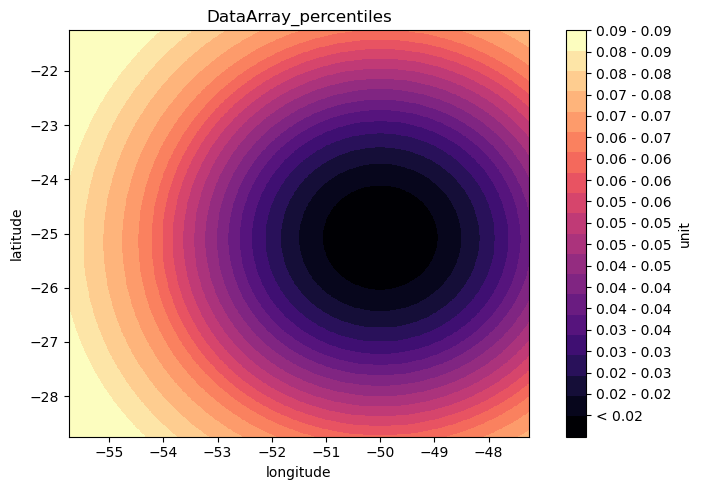

In [32]:
md.plot_DataArray_percentiles(
    angular_distance_da, 
    x='longitude', 
    y='latitude', 
    label='unit', 
    title='DataArray_percentiles', 
    cmap='magma', 
    num_classes=20
    )

In [ ]:
# Transforma em DataArray com as mesmas coordenadas do original
angular_distance_da = xr.DataArray(
    data=angular_distance,
    dims=["latitude", "longitude"],
    coords={"latitude": elevation.latitude, "longitude": elevation.longitude},
    name="angular_distance"
)

In [ ]:
# Criar a grade de coordenadas (equivalente ao broadcast)
lon_grid, lat_grid = np.meshgrid(elevation["longitude"].values, lat_geoc)

# Calcular deltas em metros (assumindo 1'' = 30m em ambas as direções)
delta_lat = (lat_grid - latP) #* 3600 * 30  # em metros
delta_lon = (lon_grid - longP) #* 3600 * 30  # em metros

# Distância horizontal r
angular_distance = angular_distance_grid(latP, longP, lat_sph, lon_sph)


unique_x = np.unique(lon_grid[0, :])
unique_y = np.unique(lat_grid[:, 0])

distance = xr.DataArray(
    distance,
    coords={
        "latitude": unique_y,
        "longitude": unique_x
    },
    dims=("latitude", "longitude")
)
distance.name = "distance"

distance = distance.interp_like(elevation)

md.plot_DataArray_percentiles(
    distance, 
    x='longitude', 
    y='latitude', 
    label='unit', 
    title='DataArray_percentiles', 
    cmap='magma', 
    num_classes=20
    )

In [ ]:


print(f"lat_geoc: {lat_geoc}°")

lat_geoc: -25.299383074323547°


In [12]:
print(radius)

6375135.590857506


In [8]:
# Calculate resolution in degrees along the longitude and latitude directions
res_longitude = np.mean(np.abs(np.diff(elevation.coords['longitude'].values)))
res_latitude = np.mean(np.abs(np.diff(elevation.coords['latitude'].values)))
res = np.median([res_longitude, res_latitude]) # Resolução em °
res_metros = round((res * 30)*3600) # Resolução em metros
res_metros_2=res_metros**2 # Resolução em metros ao quadrado


print(f"Resolution in degrees: {res}°")
print(f"Resolution in meters: {res_metros}m")
print(f"Resolution in square meters: {res_metros_2} m²")

Resolution in degrees: 0.008333333333333331°
Resolution in meters: 900m
Resolution in square meters: 810000 m²
